In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
awsaf49_brats20_dataset_training_validation_path = kagglehub.dataset_download('awsaf49/brats20-dataset-training-validation')

print('Data source import complete.')


Data source import complete.


In [ ]:
pip install nibabel matplotlib scikit-image opencv-python tensorflow


In [ ]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt

In [ ]:
BASE_PATH = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData"

IMG_SIZE = 128  # Resize to speed up training

In [ ]:
def load_nifti_image(filepath):
    img = nib.load(filepath)
    img_data = img.get_fdata()
    return img_data

In [ ]:
def normalize_img(img):
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

In [ ]:
def preprocess_single_case(img_path, mask_path):
    img_data = normalize_img(load_nifti_image(img_path))
    mask_data = load_nifti_image(mask_path)

    # Choose the middle slice for simplicity (can use 3D later)
    mid_slice = img_data.shape[2] // 2
    img_slice = cv2.resize(img_data[:, :, mid_slice], (IMG_SIZE, IMG_SIZE))
    mask_slice = cv2.resize(mask_data[:, :, mid_slice], (IMG_SIZE, IMG_SIZE))

    # Binary mask: tumor vs no tumor
    mask_slice = (mask_slice > 0).astype(np.float32)

    return img_slice[..., np.newaxis], mask_slice[..., np.newaxis]

In [ ]:
img, mask = preprocess_single_case(
    "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii",
    "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii"
)


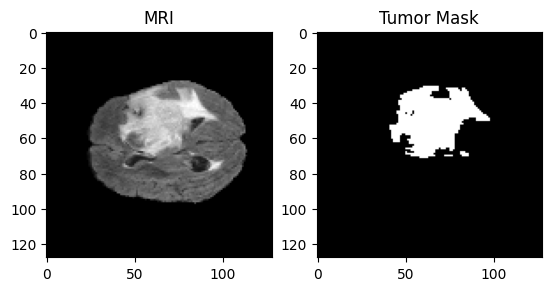

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(), cmap='gray')
plt.title('MRI')
plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title('Tumor Mask')
plt.show()

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model

def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(2)(c1)

    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(2)(c2)

    c3 = Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(128, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(2)(c3)

    # Bottleneck
    c4 = Conv2D(256, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(256, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(128, 2, strides=2, padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(128, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(128, 3, activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(64, 2, strides=2, padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(64, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(64, 3, activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(32, 2, strides=2, padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(32, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(32, 3, activation='relu', padding='same')(c7)

    outputs = Conv2D(1, 1, activation='sigmoid')(c7)

    return Model(inputs, outputs)


In [ ]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    131,200 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │     32,832 │ conv2d_9[0][0]  

 Total params: 1,925,025 (7.34 MB)

 Trainable params: 1,925,025 (7.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import glob
import os

def load_dataset(num_cases=10):  # You can increase this later
    X, Y = [], []
    base_folder = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

    folders = sorted(glob.glob(base_folder + "/BraTS20_Training_*"))[:num_cases]

    for folder in folders:
        flair = os.path.join(folder, os.path.basename(folder) + "_flair.nii")
        seg = os.path.join(folder, os.path.basename(folder) + "_seg.nii")

        img, mask = preprocess_single_case(flair, seg)
        X.append(img)
        Y.append(mask)

    return np.array(X), np.array(Y)

X_train, Y_train = load_dataset(num_cases=300)  # You can increase for better training
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)


X_train shape: (300, 128, 128, 1)
Y_train shape: (300, 128, 128, 1)


In [ ]:
history = model.fit(
    X_train, Y_train,
    epochs=25,
    batch_size=4,
    validation_split=0.2
)


Epoch 1/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.9416 - loss: 0.3142 - val_accuracy: 0.9642 - val_loss: 0.1044
Epoch 2/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9698 - loss: 0.0782 - val_accuracy: 0.9642 - val_loss: 0.0985
Epoch 3/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9696 - loss: 0.0776 - val_accuracy: 0.9642 - val_loss: 0.1026
Epoch 4/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9682 - loss: 0.0689 - val_accuracy: 0.9642 - val_loss: 0.0843
Epoch 5/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9705 - loss: 0.0682 - val_accuracy: 0.9642 - val_loss: 0.0710
Epoch 6/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9706 - loss: 0.0542 - val_accuracy: 0.9642 - val_loss: 0.0625
Epoch 7/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9757 - loss: 0.0510 - val_accuracy: 0.9787 - val_loss: 0.0561
Epoch 8/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9833 - loss: 0.0459 - val_accuracy: 0.9815 -

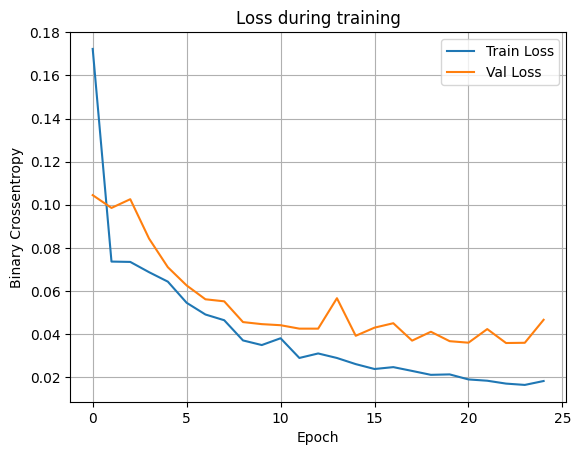

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


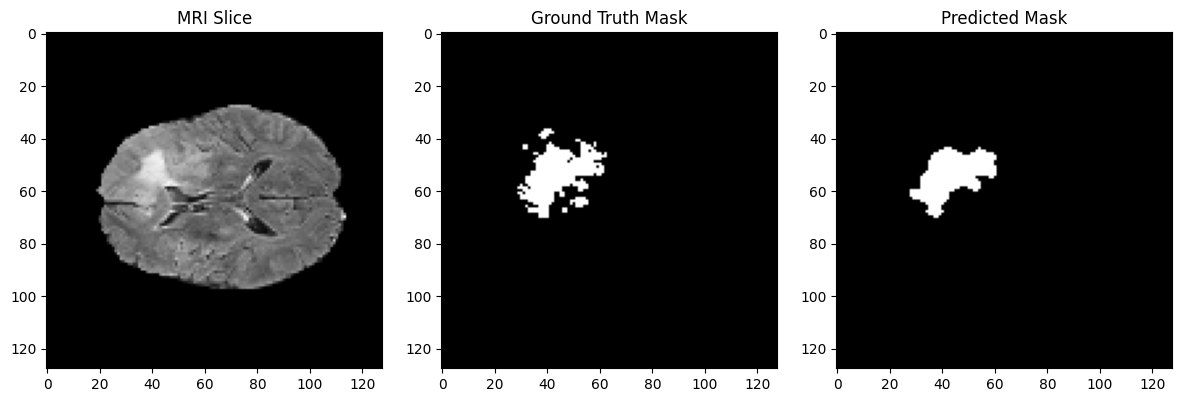

In [ ]:
# Pick a random test image (or reuse from earlier)
test_img, test_mask = preprocess_single_case(
    "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_030/BraTS20_Training_030_flair.nii",
    "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_030/BraTS20_Training_030_seg.nii"
)

# Add batch dimension
test_input = np.expand_dims(test_img, axis=0)

# Predict tumor mask
pred_mask = model.predict(test_input)[0]

# Threshold the prediction (since it's sigmoid output)
pred_mask = (pred_mask > 0.5).astype(np.float32)

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(test_img.squeeze(), cmap='gray')
plt.title('MRI Slice')

plt.subplot(1, 3, 2)
plt.imshow(test_mask.squeeze(), cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title('Predicted Mask')

plt.tight_layout()
plt.show()


In [ ]:
!pip install pennylane --quiet


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


In [ ]:
from sklearn.preprocessing import LabelEncoder
import cv2

def prepare_quantum_data(X, Y, img_size=4):
    X_q, y_q = [], []

    for img, mask in zip(X, Y):
        label = 1 if np.sum(mask) > 0 else 0  # Tumor present or not

        # Resize to (img_size, img_size)
        resized = cv2.resize(img.squeeze(), (img_size, img_size))

        # Flatten the resized image (img_size x img_size -> img_size**2 features)
        X_q.append(resized.flatten())
        y_q.append(label)

    return np.array(X_q), np.array(y_q)

X_q, y_q = prepare_quantum_data(X_train, Y_train, img_size=2)  # Resize to 2x2 for 4 features
X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(X_q, y_q, test_size=0.2, random_state=42)

print("Quantum input shape:", X_train_q.shape)



In [ ]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]


In [ ]:
class QuantumClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        weight_shapes = {"weights": (3, n_qubits)}  # 3 layers
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        self.fc = nn.Linear(n_qubits, 1)

    def forward(self, x):
        x = self.q_layer(x)
        x = self.fc(x)
        return torch.sigmoid(x)


In [ ]:
model = QuantumClassifier()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model again
X_tensor = torch.tensor(X_train_q, dtype=torch.float32)
y_tensor = torch.tensor(y_train_q, dtype=torch.float32).view(-1, 1)

for epoch in range(20):
    optimizer.zero_grad()
    preds = model(X_tensor)
    loss = loss_fn(preds, y_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")



In [ ]:
X_test_tensor = torch.tensor(X_test_q, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_q, dtype=torch.float32).view(-1, 1)

with torch.no_grad():
    test_preds = model(X_test_tensor)
    test_preds = (test_preds > 0.5).float()
    accuracy = (test_preds == y_test_tensor).float().mean()
    print("Test Accuracy:", accuracy.item())


In [ ]:
# After training
torch.save(model.state_dict(), "brain_tumor_qcnn_model.pth")